In [1]:
import pandas as pd
import glob
import re

# Define column structure based on utils.py's process_result
columns = [
    "timestamp",
    "case_uuid",
    "run_name",
    "x0",
    "x1",
    "x2",
    "x3",
    "x4",
    "x5",  # CST parameters
    "no_clipping",
    "block_mesh_result",
    "check_mesh_result",
    "simple_result",
    "has_converged",
    "vx",
    "vy",
    "vz",
    "cl",
    "cd",  # Fluid properties
]


def process_results():
    # Read and combine all CSV files
    dfs = []
    for f in glob.glob("./results/csv/results*.csv"):
        # Extract seed from filename using regex
        seed = int(re.search(r"results(\d+)\.csv", f).group(1))

        # Read CSV with proper column mapping
        df = pd.read_csv(f, header=None, names=columns)

        # Add seed column from filename
        df["seed"] = seed
        dfs.append(df)

    # Combine dataframes
    processed_df = pd.concat(dfs)

    # Clean and transform data
    analysis_df = processed_df.assign(cl_cd_ratio=lambda x: x["cl"] / x["cd"]).query(
        "has_converged == True"
    )  # Filter successful runs

    return analysis_df


# Run analysis
analysis_df = process_results()

In [2]:
from scipy import stats


def generate_paper_metrics(df):
    # 1. Optimization Performance Summary
    optimization_stats = (
        df.groupby("seed")
        .agg({"cl_cd_ratio": ["max", "mean", "std"], "cl": "max", "cd": "min"})
        .reset_index()
    )

    # 2. Parameter Sensitivity
    param_cols = ["x0", "x1", "x2", "x3", "x4", "x5"]
    corr_matrix = df[param_cols + ["cl_cd_ratio"]].corr()

    # 3. Seed Consistency Check
    seed_anova = df[["seed", "cl_cd_ratio"]].groupby("seed")
    f_val, p_val = stats.f_oneway(*[group.cl_cd_ratio for name, group in seed_anova])

    return {
        "optimization_stats": optimization_stats,
        "correlation_matrix": corr_matrix,
        "seed_consistency": {"f_value": f_val, "p_value": p_val},
    }


# Generate metrics for paper
paper_metrics = generate_paper_metrics(analysis_df)
print(paper_metrics)

{'optimization_stats':   seed cl_cd_ratio                                  cl        cd
               max       mean        std           max       min
0   27   55.420403  18.488153  15.234772  1.786997e+00  0.009540
1   42   33.043949  10.685127  10.599599  1.805752e+00  0.022721
2  232   56.620090  25.629005  15.982238  1.959678e+00  0.009819
3  321   57.281853  25.284509  16.370333  1.216279e+45  0.009906
4  395   57.128927  25.649197  16.069308  3.479820e+00 -1.020817
5  530   56.959986  22.440513  16.418290  1.957398e+00 -0.383280
6  804   57.491044  22.832458  16.304255  1.898892e+00  0.009870
7  806   56.620600  18.089062  16.133300  1.771056e+00  0.010700
8  852   58.747626  28.133528  17.222499  1.801472e+00  0.009278, 'correlation_matrix':              x0  x1  x2  x3  x4  x5  cl_cd_ratio
x0          NaN NaN NaN NaN NaN NaN          NaN
x1          NaN NaN NaN NaN NaN NaN          NaN
x2          NaN NaN NaN NaN NaN NaN          NaN
x3          NaN NaN NaN NaN NaN NaN        

Text(0.5, 0, 'Computation Time')

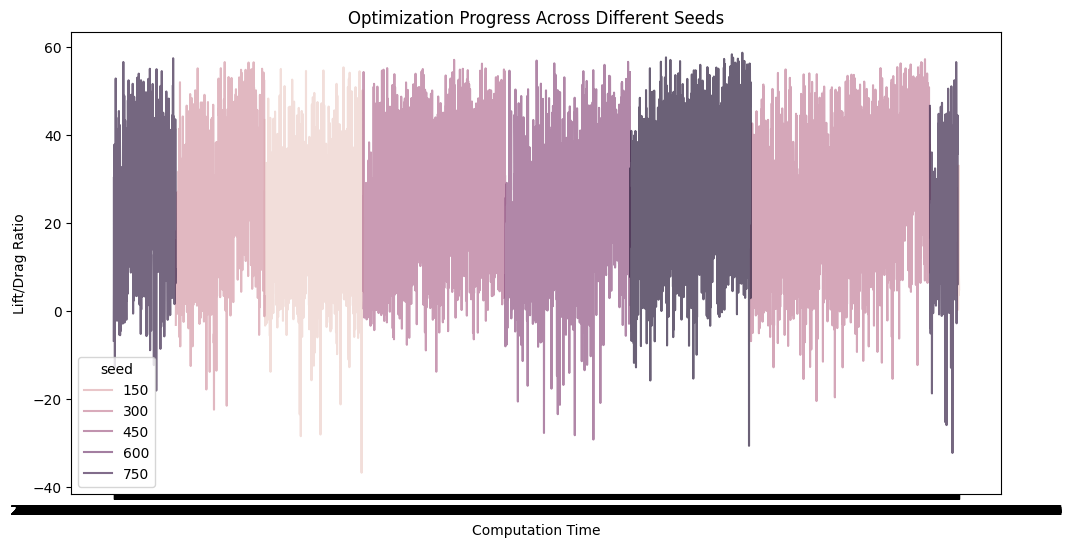

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=analysis_df,
    x="timestamp",
    y="cl_cd_ratio",
    hue="seed",
    estimator=None,
    alpha=0.7,
)
plt.title("Optimization Progress Across Different Seeds")
plt.ylabel("Lift/Drag Ratio")
plt.xlabel("Computation Time")

In [4]:
print(
    f"Seed ANOVA Results: F={paper_metrics['seed_consistency']['f_value']:.2f}, p={paper_metrics['seed_consistency']['p_value']:.4f}"
)

Seed ANOVA Results: F=26.76, p=0.0000


In [5]:
# Best performing airfoil
best_run = analysis_df.loc[analysis_df["cl_cd_ratio"].idxmax()]

# Convergence analysis
convergence_data = analysis_df.groupby("seed").apply(
    lambda g: g.sort_values("timestamp").reset_index(drop=True)
)

convergence_data.set_index("timestamp", inplace=True)

/tmp/ipykernel_103620/408340221.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  convergence_data = analysis_df.groupby('seed').apply(


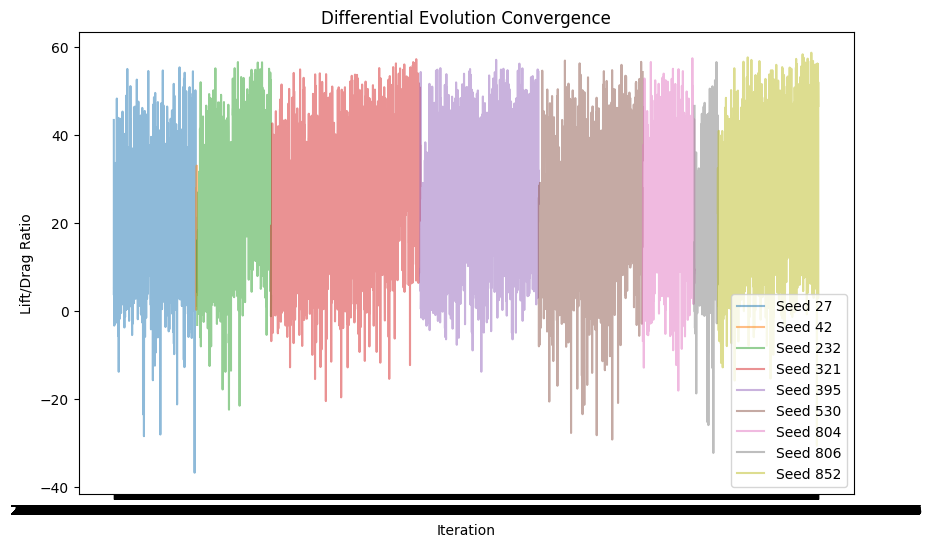

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for seed, group in convergence_data.groupby("seed"):
    plt.plot(group.index, group["cl_cd_ratio"], alpha=0.5, label=f"Seed {seed}")
plt.xlabel("Iteration")
plt.ylabel("Lift/Drag Ratio")
plt.title("Differential Evolution Convergence")
plt.legend()